In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [37]:
N = 1024

np.random.seed(0)
torch.manual_seed(0)
theta = np.sqrt(np.random.rand(N)) * 3 * np.pi
r_a = 2 * theta + np.pi
x_orig = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
x = 4*(x_orig + 0.25 *np.random.randn(N,2) + 30)
x = x.astype('uint8')
#x[:, 2] = 1
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)


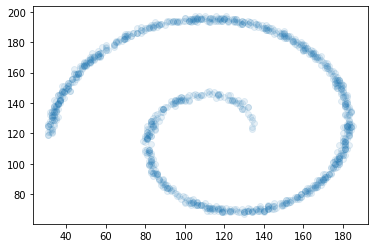

In [38]:
plt.scatter(x[:, 0], x[:, 1], alpha=0.1)

plt.show()

In [39]:
x = torch.from_numpy(x)
x_mean = torch.from_numpy(x_mean).type(torch.float32)
x_std = torch.from_numpy(x_std).type(torch.float32)

In [40]:
class Base2FourierFeatures(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs):
        freqs = torch.asarray(range(8), dtype=inputs.dtype) # [0,1,...,7]
        w = 2*torch.pi * (2.0**freqs) # 2^n * 2π
        # concatenate a copy of w column-wise
        w = torch.tile(w[None, :], (1, inputs.shape[-1]))
        # repeat input array 8 times for 8 frequencies column-wise
        h = 1.0*torch.repeat_interleave(inputs, repeats=len(freqs), dim=-1)
        #element-wise multiplication (x*2^n *2π)
        h *= w
        # apply sin and cosine to and concatenate column-wise
        h = torch.cat([torch.sin(h), torch.cos(h)], axis=-1)
        return h
        

In [41]:
init_gamma_0 = -13.3  # initial gamma_0
init_gamma_1 = 5.0  # initial gamma_1
class NoiseSchedule(nn.Module):
    def __init__(self):
        super().__init__()
        init_bias = init_gamma_0
        init_scale = init_gamma_1 - init_gamma_0
        
        self.w = nn.Parameter(data=torch.tensor([init_scale]))
        self.b = nn.Parameter(data=torch.tensor([init_bias]))
        
    def forward(self, t):
        return torch.abs(self.w)*t + self.b

In [42]:
hidden_units = 512
class ScoreNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.LazyLinear(hidden_units)
        self.layer2 = nn.LazyLinear(hidden_units)
        self.layer3 = nn.LazyLinear(2)
        self.layer_fourier = Base2FourierFeatures()
        
    def forward(self, z, gamma_t):
        gamma_lower_bound = init_gamma_0
        gamma_upper_bound = init_gamma_1
        
        # Normalize gamma_t
        gamma_t_norm = ((gamma_t - gamma_lower_bound) / (gamma_upper_bound - gamma_lower_bound)) *2 -1
        
        # Concatenate normalized gamma_t as extra feature
        x = torch.cat([z, gamma_t_norm[:, None]], axis=1) # CHANGED -1 TO 1

        # append Fourier features
        x_fourier = self.layer_fourier(x)
        x = torch.cat([x, x_fourier], axis=1)

        # forward pass
        x = F.silu(self.layer1(x))

        x = F.silu(self.layer2(x))

        return self.layer3(x)

In [43]:
class Diffusion_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.score_network = ScoreNetwork()
        self.noise_schedule = NoiseSchedule()
        
    def forward(self, x, t):
        gamma_t = self.noise_schedule(t)
        return self.score_network(x, gamma_t)
    
    def score(self, x, t):
        return self.score_network(x, t)
        
    
    def gamma(self, t):
        return self.noise_schedule(t)

In [44]:
def data_encode(x):
    x = x.round()
    return (x- x_mean) / x_std

In [45]:
vocab_size = 256

def data_decode(x_0_rescaled, gamma_0):
    
    x_vals = torch.arange(0, vocab_size)[:, None]
    x_vals = torch.repeat_interleave(x_vals, repeats=x_0_rescaled.shape[-1], dim=1)
    x_vals = data_encode(x_vals).transpose(1, 0)[None, :, :]
    inv_stdev = torch.exp(-0.5 * gamma_0[..., None])
    logits = -0.5 * torch.square((x_0_rescaled[..., None] - x_vals) * inv_stdev)
    logprobs = F.log_softmax(logits, dim=2)
    return logprobs

In [46]:
def data_logprob(x, x_0_rescaled, gamma_0):
    x = x.round()
    x_onehot = F.one_hot(x.type(dtype=torch.int64), vocab_size).type(torch.float32)
    logprobs = data_decode(x_0_rescaled, gamma_0)
    logprob = torch.sum(x_onehot * logprobs, dim=(1, 2))
    return logprob

In [47]:
T_train =40
model = Diffusion_Model()
def loss_fn(x):
    
    gamma = lambda t: model.gamma(t)
    gamma_0, gamma_1 = gamma(0.0), gamma(1.0)
    var_0, var_1 = torch.sigmoid(gamma_0), torch.sigmoid(gamma_1)
    n_batch = x.shape[0]
    
    f = data_encode(x)
    
    # RECONSTRUCTION LOSS
    eps_0 = torch.randn(size=f.shape)
    x_0 = torch.sqrt(1.0 - var_0)*f + torch.sqrt(var_0) * eps_0
    x_0_rescaled = f + torch.exp(0.5*gamma_0) * eps_0
    loss_recon = -data_logprob(x, x_0_rescaled, gamma_0)
    
    # LATENT LOSS
    mean1_sqr = (1.0 - var_1) * torch.square(f)
    loss_klz = 0.5*torch.sum(mean1_sqr + var_1 - torch.log(var_1) -1.0, dim=1)
    
    # DIFFUSION LOSS
    t = torch.rand(size=(n_batch,))
    # sample time steps
    if T_train >0:
        t = torch.ceil(t * T_train) / T_train
    
    
    gamma_t = gamma(t)
    var_t = F.sigmoid(gamma_t)[:, None]
    eps = torch.randn(size=f.shape)
    x_t = torch.sqrt(1.0 - var_t)*f + torch.sqrt(var_t) * eps
    x_t = x_t.type(torch.FloatTensor)
    # compute predicted noise
    eps_hat = model.score(x_t, gamma_t)
    #print(gamma_t.shape)
    #print(z_t.shape)
    #print(eps_hat.shape)
    #print(eps.shape)
    loss_diff_mse = torch.sum(torch.square(eps - eps_hat), dim=1)
    
    # loss for discrete time
    s = t- (1.0 / T_train)
    gamma_s = gamma(s)
    loss_diff = 0.5*T_train*torch.expm1(gamma_t - gamma_s) * loss_diff_mse
    
    # compute loss in terms of bits per dimension
    rescale_to_bpd = 1.0 / (torch.prod(torch.tensor(x.shape[1:])) * torch.log(torch.tensor(2.0)))
    bpd_latent = torch.mean(loss_klz) * rescale_to_bpd
    bpd_recon = torch.mean(loss_recon) * rescale_to_bpd
    bpd_diff = torch.mean(loss_diff) * rescale_to_bpd
    bpd = bpd_recon + bpd_latent + bpd_diff
    loss = bpd
    metrics = [bpd_latent, bpd_recon, bpd_diff]
    return loss, metrics


In [48]:
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_step(x):
    x = x.type('torch.FloatTensor')
    model.train()
    optimizer.zero_grad()
    (loss, metrics) = loss_fn(x)
    loss.backward()
    optimizer.step()
    return loss, metrics

In [21]:

num_train_steps = 20000
losses_10 = []

for i in trange(num_train_steps):
    loss, _metrics = train_step(x)
    losses_10.append(loss.detach().numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

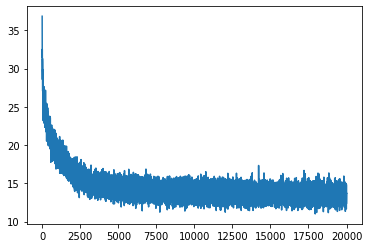

In [22]:
plt.plot(losses_10)

In [ ]:
num_train_steps = 20000
losses_40 = []

for i in trange(num_train_steps):
    loss, _metrics = train_step(x)
    losses_40.append(loss.detach().numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


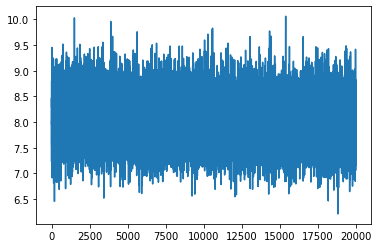

In [ ]:
plt.plot(losses_1)

In [ ]:
num_train_steps = 20000
losses_200 = []

for i in trange(num_train_steps):
    loss, _metrics = train_step(x)
    losses_200.append(loss.detach().numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


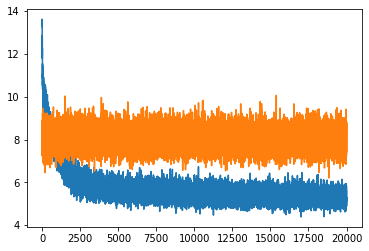

In [ ]:
plt.plot(losses_2)

In [ ]:

num_train_steps = 20000
losses_3 = []

for i in trange(num_train_steps):
    loss, _metrics = train_step(x)
    losses_3.append(loss.detach().numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
num_train_steps = 20000
losses_4 = []

for i in trange(num_train_steps):
    loss, _metrics = train_step(x)
    losses_2.append(loss.detach().numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


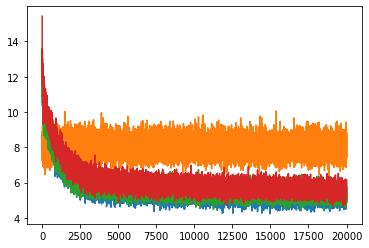

In [ ]:
plt.plot(losses)
plt.plot(losses_1)
plt.plot(losses_2)
plt.plot(losses_3)

In [24]:
model.eval()

Diffusion_Model(
  (score_network): ScoreNetwork(
    (layer1): Linear(in_features=51, out_features=512, bias=True)
    (layer2): Linear(in_features=512, out_features=512, bias=True)
    (layer3): Linear(in_features=512, out_features=2, bias=True)
    (layer_fourier): Base2FourierFeatures()
  )
  (noise_schedule): NoiseSchedule()
)

In [25]:
def sample_step(i, T_sample, x_t):
  eps = torch.randn(x_t.shape)
  t = (T_sample - i) / T_sample
  s = (T_sample - i - 1) / T_sample

  gamma_s = model.gamma(s)
  gamma_t = model.gamma(t)
  gamma_s = gamma_s * torch.ones((x_t.shape[0],), dtype=gamma_s.dtype)
  gamma_t = gamma_t *  torch.ones((x_t.shape[0],), dtype=gamma_t.dtype)

  eps_hat = model.score(x_t, gamma_t)
  a = torch.sigmoid(-gamma_s)[:, None]
  b = torch.sigmoid(-gamma_t)[:, None]
  c = -torch.expm1(gamma_s - gamma_t)[:, None]
  sigma_t = torch.sqrt(torch.sigmoid(gamma_t))[:, None]

  x_s = torch.sqrt(a / b) * (x_t - sigma_t * c * eps_hat) + torch.sqrt((1.0 - a) * c) * eps

  alpha_t = torch.sqrt(1 - b)
  x_pred = (x_t - sigma_t * eps_hat) / alpha_t

  return x_s, x_pred

In [26]:
def data_generate_x(x_0, gamma_0):
  var_0 = torch.sigmoid(gamma_0)
  x_0_rescaled = x_0/torch.sqrt(1.0 - var_0)
  logits = data_decode(x_0_rescaled, gamma_0)
  samples = torch.empty(size=logits.shape[:-1], dtype=torch.int32)
  for i in range(logits.shape[0]):
    samples[i,:] = torch.multinomial(input=F.softmax(logits, dim=-1)[i,:,:], num_samples=1).reshape(-1).type(torch.int32)
  return samples

In [27]:
def sample_fn(N_sample, T_sample):

  x = [torch.randn(size=(N_sample,2))]
  x_pred = []

  for i in trange(T_sample):
    _x, _x_pred = sample_step(i, T_sample, x[-1])
    x.append(_x)
    x_pred.append(_x_pred)

  gamma_0 = model.gamma(0.0)
  x_sample = data_generate_x(x[-1], gamma_0)
  return x, x_pred, x_sample

In [29]:
x, x_pred, _ = sample_fn(N_sample=1024, T_sample=10)

  0%|          | 0/10 [00:00<?, ?it/s]

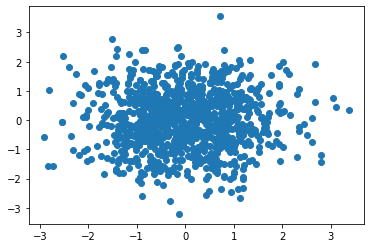

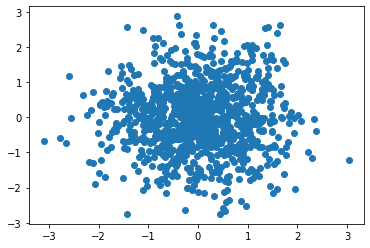

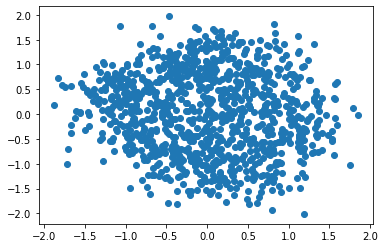

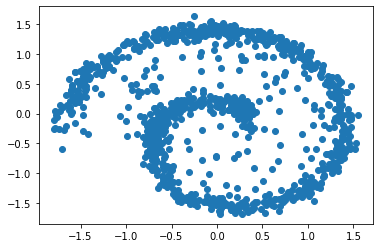

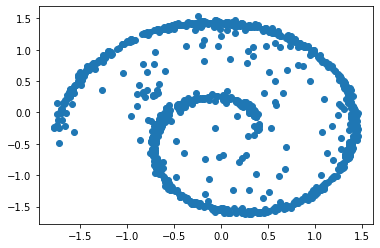

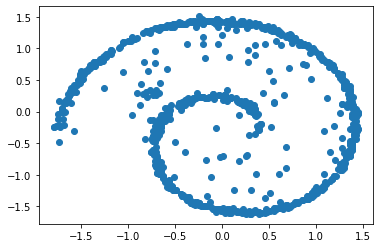

In [31]:
for t in range(0,11,2):
  data = x[t].detach().numpy()
  plt.scatter(data[:,0], data[:,1])
  plt.savefig('spiral'+f'{t}'+'.png')
  plt.show()

In [ ]:
x, x_pred, _ = sample_fn(N_sample=1024, T_sample=200)

In [ ]:
x_estimated = np.array([data[:,0], data[:,1]])
x_estimated.shape

(2, 1024)

In [ ]:
np.max(x_estimated[:,0]), np.min(x_estimated[:,1])

(1.4813671, -1.6241424)

In [ ]:
x_orig.shape

(1024, 2)

In [ ]:
def predict_grad(t, x_t):
  gamma_t = model.gamma(t)
  gamma_t = gamma_t *  torch.ones((x_t.shape[0],), dtype=gamma_t.dtype)
  eps_hat = model.score(x_t, gamma_t)
  sigma_t = torch.sqrt(torch.sigmoid(gamma_t))[:, None]
  grad = -eps_hat #/ sigma_t
  return grad


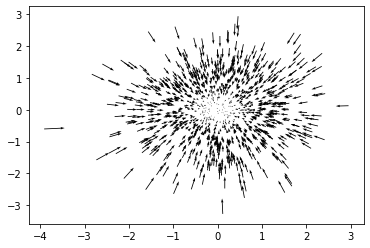

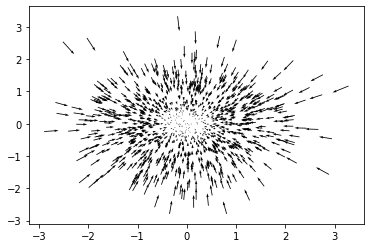

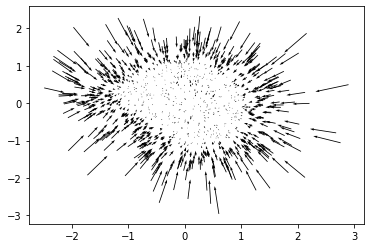

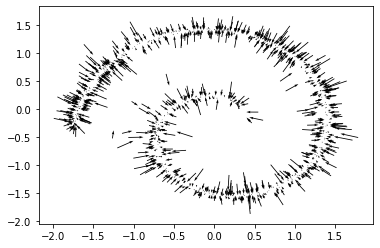

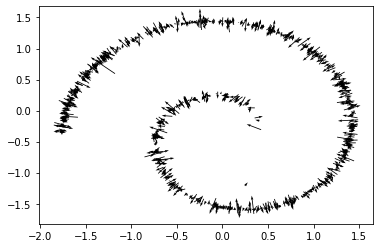

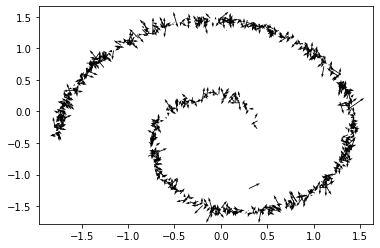

In [ ]:
for i in range(0,201, 40):
  t = (200 - i) / 200
  grad_pred = predict_grad(t, x[i])
  plt.quiver(x[i][:,0].detach().numpy(), x[i][:,1].detach().numpy(), grad_pred[:,0].detach().numpy(), grad_pred[:,1].detach().numpy())
  plt.show()